In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statistics
import math
import datetime
import operator
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score as acc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

In [33]:
#from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import RandomOverSampler

Using TensorFlow backend.


In [6]:
def reader(file):
    csv = open(file, 'r',encoding="utf8", errors='ignore')
    data =  pd.read_csv(csv)
    return data

In [8]:
Training_complete = pd.read_csv('/Users/liweizhang/Columbia University/cu_semester2/GitHub/ADA-Project-LoVEWtc/Group0/Training Data.csv')

In [9]:
Training_complete

,Unnamed: 0,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,2987000,0,86400,68.50,4,13926,NaN,150.0,1,...,NaN,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,1,2987001,0,86401,29.00,4,2755,404.0,150.0,2,...,NaN,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,2,2987002,0,86469,59.00,4,4663,490.0,150.0,3,...,NaN,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,3,2987003,0,86499,50.00,4,18132,567.0,150.0,2,...,NaN,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,4,2987004,0,86506,50.00,1,4497,514.0,150.0,2,...,144.0,1,1,123,1,0,1,1,1,954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,590535,3577535,0,15811047,49.00,4,6550,NaN,150.0,3,...,NaN,-1,-1,-1,-1,-1,-1,-1,-1,-1
590536,590536,3577536,0,15811049,39.50,4,10444,225.0,150.0,2,...,NaN,-1,-1,-1,-1,-1,-1,-1,-1,-1
590537,590537,3577537,0,15811079,30.95,4,12037,595.0,150.0,2,...,NaN,-1,-1,-1,-1,-1,-1,-1,-1,-1
590538,590538,3577538,0,15811088,117.00,4,7826,481.0,150.0,2,...,NaN,-1,-1,-1,-1,-1,-1,-1,-1,-1


### Fill the missing value by Mulitple Imuptation and Mode(for categorical data)

In [10]:
# Filling the missing value with Mode and Multiple imputation(based on linear regression)
def multiple_linear_fit(df,replicates):
    for columns in list(df.columns):
        #if not isinstance(df[columns][0],str):
        if columns  not in ['dist1' ,'dist2' ,'card2'] and columns[0] !='D':
            df[columns].fillna(df[columns].mode()[0],inplace = True)
    complete_cols_df = df[df.columns[df.isna().sum() == 0].tolist()]
    #complete_cols_df = complete_cols_df.drop( [x for x in complete_cols_df.columns if isinstance(complete_cols_df[x][0],str)],axis = 1 )
    uncomplete_cols = df.columns[df.isna().any()].tolist()
    for col in uncomplete_cols:
        complete_cols_df[col] = df[col]
        known_part = complete_cols_df[complete_cols_df[col].notna()].as_matrix()
        unknown_part = complete_cols_df[complete_cols_df[col].isna()].as_matrix()
        y = known_part[:, -1]
        X = known_part[:,0:complete_cols_df.shape[1]-2]
        
        lrg = LinearRegression()
        #print(X, y)
        lrg.fit(X, y)
        cnt = 0
        predictedAges = lrg.predict(unknown_part[:,0:complete_cols_df.shape[1]-2])
        for cnt in range(0,replicates-1):
            predictedAges += lrg.predict(unknown_part[:,0:complete_cols_df.shape[1]-2])
            cnt += 1
        df.loc[ (df[col].isna()), col ] = predictedAges/replicates
        complete_cols_df[col] = df[col]
    return df

Training_complete = multiple_linear_fit(Training_complete,5)


In [11]:
start_time = datetime.datetime.now() 
datafinal = Training_complete
key = list(datafinal.columns)[:-1]
dic = {x:True for x in key}
for i in tqdm(range(len(key))):
    mk = statistics.mean(datafinal[key[i]])
    mki_0 = statistics.mean(datafinal[datafinal['isFraud'] == 0][key[i]])
    mki_1 = statistics.mean(datafinal[datafinal['isFraud'] == 1][key[i]])
    sigmabetween = math.pow((mki_0 - mk),2) + math.pow((mki_1 - mk),2)
    counter_0 = sum(np.array(datafinal[datafinal['isFraud'] == 0][key[i]] - mki_0)**2)
    counter_1 = sum(np.array(datafinal[datafinal['isFraud'] == 1][key[i]] - mki_1)**2)
    ni = datafinal.shape[0]
   # for j in tqdm(range(datafinal[datafinal['isFraud'] == 0].shape[0])):
   #     counter_0 += math.pow((datafinal[datafinal['isFraud'] == 0][key[i]].iloc[j] - mki_0),2)
   # for k in tqdm(range(datafinal[datafinal['isFraud'] == 1].shape[0])):    
   #     counter_1 += math.pow((datafinal[datafinal['isFraud'] == 1][key[i]].iloc[k] - mki_1),2)
    sigmain = 1/ni*(counter_0+counter_1)
    if sigmain == 0:
        sigmain = 0.0001
    fc = sigmabetween/sigmain
    dic[key[i]] = fc
dic
end_time = datetime.datetime.now()
interval = (end_time - start_time).total_seconds()
print ('time used:',interval)

100%|██████████| 360/360 [22:26<00:00,  3.53s/it]

time used: 1346.420519


In [12]:
sorted_dic = sorted(dic.items(), key=operator.itemgetter(1),reverse=True)
top20 = []
for i in range(1,21):
    top20.append(sorted_dic[i][0])
top20 

['V257',
 'V246',
 'V244',
 'V242',
 'V201',
 'V200',
 'V45',
 'V189',
 'V86',
 'V87',
 'V258',
 'V188',
 'V44',
 'V228',
 'V170',
 'V52',
 'V171',
 'V199',
 'V51',
 'V230']

In [13]:
datagroup = datafinal[top20+['isFraud']]
datagroup

,V257,V246,V244,V242,V201,V200,V45,V189,V86,V87,...,V188,V44,V228,V170,V52,V171,V199,V51,V230,isFraud
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0
590536,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0
590537,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0
590538,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    datagroup.values[:,:-1],
    datagroup.values[:,-1:],
    test_size=0.4,
    random_state=42)
y_train = y_train.ravel()
y_test = y_test.ravel()
print('Training dataset shape:', X_train.shape, y_train.shape)
print('Testing dataset shape:', X_test.shape, y_test.shape)
clf = LogisticRegression()
sfs1 = sfs(clf,
           k_features=6,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

Training dataset shape: (354324, 20) (354324,)
Testing dataset shape: (236216, 20) (236216,)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   21.2s finished

[2019-12-01 13:13:20] Features: 1/6 -- score: 0.9682098864693595[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   25.3s finished

[2019-12-01 13:13:45] Features: 2/6 -- score: 0.9685626716832385[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   29.9s finished

[2019-12-01 13:14:15] Features: 3/6 -- score: 0.9687856307114341[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

In [20]:
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 3, 6, 10, 11, 13]


In [21]:
selectedfeatures = []
for i in range(0,len(feat_cols)):
    selectedfeatures.append(top20[feat_cols[i]])
selectedfeatures = datagroup[selectedfeatures + ['isFraud']]
selectedfeatures

,V257,V242,V45,V258,V188,V228,isFraud
0,1.0,1.0,1.0,1.0,1.0,1.0,0
1,1.0,1.0,1.0,1.0,1.0,1.0,0
2,1.0,1.0,1.0,1.0,1.0,1.0,0
3,1.0,1.0,1.0,1.0,1.0,1.0,0
4,1.0,1.0,1.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...
590535,1.0,1.0,1.0,1.0,1.0,1.0,0
590536,1.0,1.0,1.0,1.0,1.0,1.0,0
590537,1.0,1.0,1.0,1.0,1.0,1.0,0
590538,1.0,1.0,1.0,1.0,1.0,1.0,0


In [34]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    selectedfeatures.values[:,:-1],
    selectedfeatures.values[:,-1:],
    test_size=0.25,
    random_state=42)
y_train_1 = y_train_1.ravel()
y_test_1 = y_test_1.ravel()
print('Training dataset shape:', X_train_1.shape, y_train_1.shape)
print('Testing dataset shape:', X_test_1.shape, y_test_1.shape)
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X_train_1, y_train_1)
#ros = RandomOverSampler(random_state=2)
#X_sm, y_sm = ros.fit_resample(X_train_1, y_train_1)
logisticRegr = LogisticRegression()
logisticRegr.fit(X_sm,y_sm)
predictions = logisticRegr.predict(X_test_1)
recall_score(y_test_1, predictions)

Training dataset shape: (442905, 6) (442905,)
Testing dataset shape: (147635, 6) (147635,)


0.37285579641847316

In [14]:
metrics.precision_score(y_test_1,predictions )

0.17775981316805892

In [15]:
f1_score(y_test_1,predictions)

0.2407835503102567

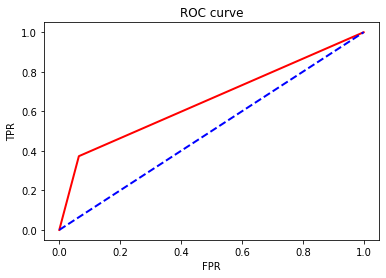

In [16]:
##Computing false and true positive rates
fpr, tpr,_=roc_curve(y_test_1,predictions,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [23]:
from sklearn.linear_model import LogisticRegressionCV

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(
    selectedfeatures.values[:,:-1],
    selectedfeatures.values[:,-1:],
    test_size=0.25,
    random_state=42)
y_train_1 = y_train_1.ravel()
y_test_1 = y_test_1.ravel()


In [35]:
logisticRegr_cv = LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial').fit(X_sm,y_sm)

In [36]:
logisticRegr_cv.score(X_sm,y_sm) 

0.6527633219271799

In [37]:
predictions_cv = logisticRegr_cv.predict(X_test_1)
recall_score(y_test_1, predictions_cv)

0.37285579641847316

In [38]:
metrics.precision_score(y_test_1,predictions_cv)

0.17759023163943258

In [39]:
f1_score(y_test_1,predictions_cv)

0.24058870035881533

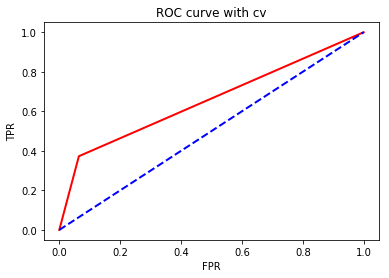

In [40]:
fpr_cv, tpr_cv, _=roc_curve(y_test_1,predictions_cv,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()
##Adding the ROC
plt.plot(fpr_cv, tpr_cv, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve with cv')
plt.show()

In [45]:
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
def logistic_cross_validation(data, folder_num):
    X_train, X_val, y_train, y_val = train_test_split(data[:,:-1], data[:,-1:], test_size=0.25, random_state=42)
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    
    
    

In [ ]:
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X_train_1, y_train_1)
#ros = RandomOverSampler(random_state=2)
#X_sm, y_sm = ros.fit_resample(X_train_1, y_train_1)
logisticRegr = LogisticRegression()
logisticRegr.fit(X_sm,y_sm)
predictions = logisticRegr.predict(X_test_1)
recall_score(y_test_1, predictions)

In [46]:
kf = KFold(n_splits=5)
X = X_train_1
y = y_train_1
accu_lst = []
fscore_lst = []
precision_lst = []
recall_lst = []
auc_lst = []

for fold, (train_index, val_index) in enumerate(kf.split(X), 1):
    X_train_cv = X[train_index]
    y_train_cv = y[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
    X_val_cv = X[val_index]
    y_val_cv = y[val_index]  # See comment on ravel and  y_train
    sm = SMOTE()
    X_train_oversampled_cv, y_train_oversampled_cv = sm.fit_sample(X_train_cv, y_train_cv)
    model = logisticRegr  # Choose a model here
    model.fit(X_train_oversampled_cv, y_train_oversampled_cv)  
    y_pred_cv = model.predict(X_val_cv)
    
    acc_ = model.score(X_val_cv, y_val_cv)
    fscore_ = f1_score(y_val_cv, y_pred_cv)
    precision_ = metrics.precision_score(y_val_cv, y_pred_cv)
    recall_ = recall_score(y_val_cv, y_pred_cv)
    auc_ = roc_auc_score(y_val_cv, y_pred_cv)
    
    accu_lst.append(acc_)
    fscore_lst.append(fscore_)
    precision_lst.append(precision_)
    recall_lst.append(recall_)
    auc_lst.append(auc_)
    
    print(f'For fold {fold}:')
    print(f'Accuracy: {acc_}')
    print(f'f-score: {fscore_}')
    print(f'precision: {precision_}')
    print(f'recall: {recall_}')
    print(f'auc: {auc_}')

print('Mean accuracy of cross validation is ',np.mean(accu_lst))
print('Mean fscore of cross validation is ',np.mean(fscore_lst))
print('Mean precision of cross validation is ',np.mean(precision_lst))
print('Mean recall of cross validation is ',np.mean(recall_lst))
print('Mean auc of cross validation is ',np.mean(auc_lst))
    

For fold 1:
Accuracy: 0.9142931328388706
f-score: 0.2335958005249344
precision: 0.16824196597353497
recall: 0.38197424892703863
auc: 0.6575571637378788
For fold 2:
Accuracy: 0.9157494270780415
f-score: 0.23322716531388057
precision: 0.1716835577068522
recall: 0.3635490070467649
auc: 0.6497357480968036
For fold 3:
Accuracy: 0.9159526309253677
f-score: 0.23539077744685222
precision: 0.17150553726429213
recall: 0.3751227495908347
auc: 0.6551969476036862
For fold 4:
Accuracy: 0.9145866495072307
f-score: 0.2285889070146819
precision: 0.1656079184517654
recall: 0.3688713392563343
auc: 0.6514226467855869
For fold 5:
Accuracy: 0.9143495783520168
f-score: 0.22888504929362744
precision: 0.16741005055010408
recall: 0.3617089624156762
auc: 0.6480936818443336
Mean accuracy of cross validation is  0.9149862837403054
Mean fscore of cross validation is  0.23193753991879534
Mean precision of cross validation is  0.16888980598930975
Mean recall of cross validation is  0.3702452614473298
Mean auc of cros